<a href="https://colab.research.google.com/github/rhiats/breastCancerClassification/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
!pip install shap
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
bc_data = load_breast_cancer()
df = pd.DataFrame(bc_data.data, columns=bc_data.feature_names)
df['Target'] = bc_data.target
df.insert(0, 'ID', range(0, len(df)))
df.head()

,ID,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df.columns

Index(['ID', 'mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'Target'],
      dtype='object')

In [4]:
X=df.drop(['Target'],axis=1)
y=df['Target']

**Class Balance**

There is significant class imbalance between the Benign and Malignant class, so majority class undersampling is used to balance the classes.

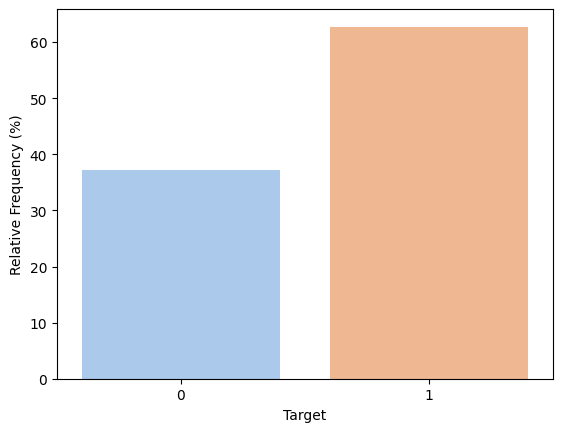

In [5]:
def balanced(df):
  """
    Percentage of people with Benign and malignant tumors
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """

  ratio_df=(df[['ID','Target']].groupby('Target').count()/df.shape[0])*100

  ratio_df.reset_index(inplace=True)

  ratio_df.rename(columns={"ID": "Relative Frequency (%)"}, inplace=True)

  sns.barplot(data=ratio_df, x='Target', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/output/balanced.png")

balanced(df)

**Undersampling**

In [6]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
df_under=pd.concat([X_under, y_under],ignore_index=True,axis=1)
df_under.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**PCA**

The first principle component explains 98% of the variance. The top 5 features from the component are 'worst area,' 'mean area,' 'area error,' 'worst perimeter,' and 'mean perimeter.'

In [7]:
pca = PCA(n_components=2)
X=X_under.to_numpy()
X=X[:,1:]
X = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=df.columns[1:-1])
loadings.sort_values(by=['PC1'], ascending=False)

Explained variation per principal component: [0.98045162 0.01763546]


,PC1,PC2
worst area,8.538247e-01,-5.171996e-01
mean area,5.139058e-01,8.534557e-01
area error,5.722081e-02,1.941450e-02
worst perimeter,4.848089e-02,-2.866030e-03
mean perimeter,3.418546e-02,5.929967e-02
worst radius,7.016055e-03,-1.077433e-03
mean radius,4.958280e-03,8.701304e-03
worst texture,2.800830e-03,-1.156348e-02
perimeter error,2.255929e-03,1.482069e-03
mean texture,2.025336e-03,-1.815603e-03


**Project Instances for Visualization**

The classes are not linearly separaple and there is some overlap between the benign and malignant cells. The malignant cells are very dispersed in there characteristics.

<Figure size 640x480 with 0 Axes>

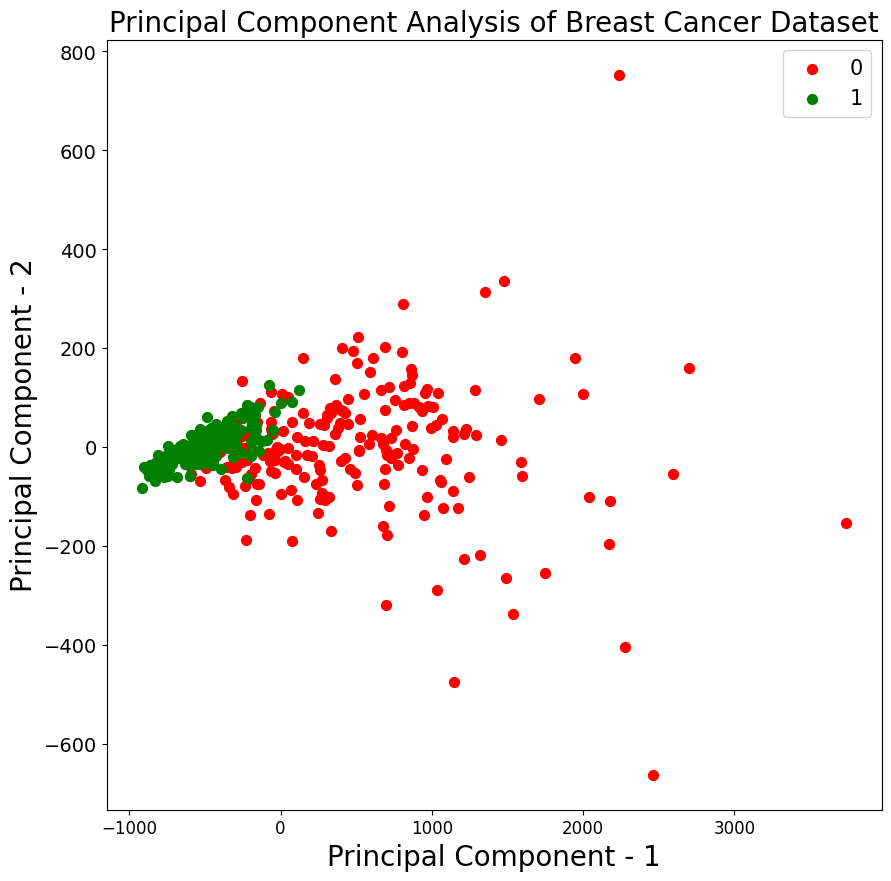

In [8]:
principalComponents_arr = pca.fit_transform(X)
principalComponents_df= pd.DataFrame(principalComponents_arr, columns = ['PC1','PC2'])

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    df_target=df_under[df_under[31] == target]
    indicesToKeep=df_target.index
    plt.scatter(principalComponents_df.loc[indicesToKeep, 'PC1'] , principalComponents_df.loc[indicesToKeep, 'PC2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.savefig("/content/drive/MyDrive/output/pca.png")

**Random Forest**

In [22]:
X_under_s=X_under[[ 'worst area', 'mean area','area error', 'worst perimeter', 'mean perimeter']]
X_train, X_test, y_train, y_test = train_test_split(X_under_s, y_under, test_size=0.5, random_state=0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf=clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

**Evaluation**

The accuracy is 0.89
Model AUC score: 0.8915094339622642
Confusion Matrix
 [[ 87  19]
 [  4 102]]
The precision score: 0.8429752066115702

 The recall score: 0.9622641509433962 




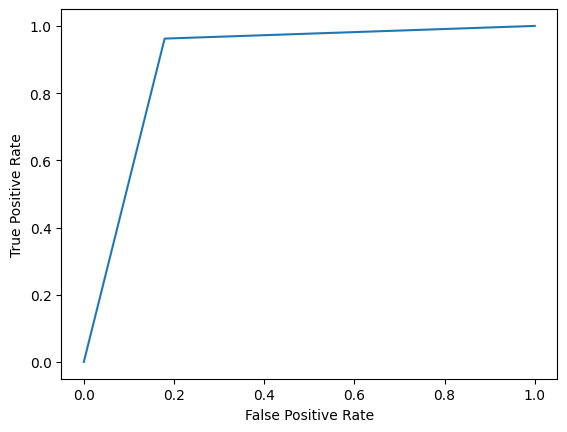

In [23]:
print("The accuracy is {}".format(round(accuracy_score(y_test, y_pred),2)))
def plot_roc_curve(true_y, y_prob):
    """
    Plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig("/content/drive/MyDrive/output/ROC_curve.png")

plot_roc_curve(y_test,y_pred)
print(f'Model AUC score: {roc_auc_score(y_test,y_pred)}')
cf_mat = confusion_matrix(y_test,y_pred)
print("Confusion Matrix\n",cf_mat)
print("The precision score: {}\n\n The recall score: {} \n\n".format(precision_score(y_test,y_pred), recall_score(y_test,y_pred)))

**Feature Importance**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


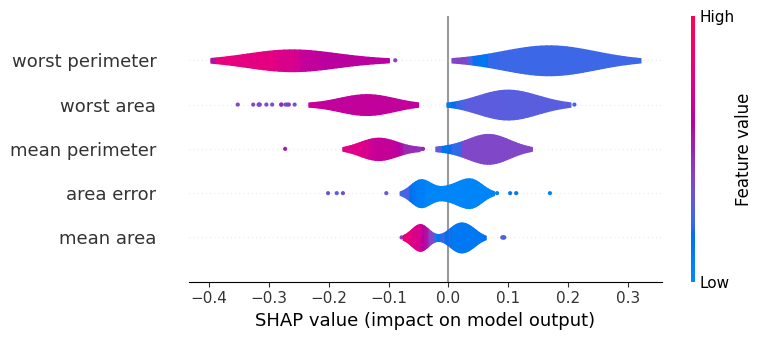

In [24]:
explainer = shap.Explainer(clf.predict,X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, plot_type='violin')

**References**

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/